# Dwave dataset
- Training RBM to learn distribution of Dwave output

# Tasks
1. Generate 10000 samples
2. Ensure the samples are generated from an equilibrated model. What metric do you use to prove equilibrium?
3. Report the mean of each Ising variable
4. Report the mean correlation of pairs of variables listed

#### Training
- We first train RBM using PCD and track likelihood of training data to see if it converges.
- Visible node count = 2041 is quite a high demand. With time limited for the cohort, the training is incomplete.
 - I could not use sufficient node count ~O(visible) for hidden nodes.
 - I could not use sufficient CD-k steps ~O(visible).
 - I could not do sufficient epochs.

- Convergence, i.e. equilibrium, are tracked while training using log-likelihood .

In [ ]:
from datetime import datetime
import pandas as pd
import torch
from helper import load_dataset
train_data, test_data = load_dataset('dataset_x1a46w3557od23s750k9.npz')
df = pd.read_csv('correlated_features.csv')

from RBM_helper import RBM

total_data_count, visible_nodes = train_data.shape


n_vis = visible_nodes
n_hin = int(n_vis / 10)
rbm = RBM(n_vis, n_hin)

train_data = torch.Tensor(train_data)

def train(rbm):
    epochs = 100
    # num_samples = visible_nodes * 10
    k_train = 100
    k_validate = n_vis + n_hin
    print('Starting training on n_h = ', n_hin)
    energies = []
    for e in range(1, epochs+1):
        # do one epoch of training
        start = datetime.now()
        rbm.train(train_data, k=k_train)
        end = datetime.now()
        print(f"Elapsed {end - start} for epoch {e}")
        # now generate samples and calculate the energy
        if e % 10 == 0:
            print("\nEpoch: ", e)
            # We check if log likelihood of training data converges
            energy = rbm.effective_energy(train_data).item()
            energies.append(energy)
            print("Energy : ", energy)
    return energies

In [ ]:
likelihooods = train(rbm)
rbm.save_params('dwave_k100_e400')
df = pd.DataFrame(likelihoods)
df.to_csv('dwave_k100_e400_ll.csv')

## 1 Drawing samples
- Drawing from random state

In [4]:
import torch
from RBM_helper import RBM
from datetime import datetime
rbm = RBM.from_weights('dwave_k100_e400')
n_vis = rbm.n_vis
sample_count = 10000
k = 1000
initial_state = torch.rand((sample_count, n_vis)).cuda()
rbm = rbm.to(initial_state)
start = datetime.now()
samples = rbm.draw_samples(k, initial_state)
end = datetime.now()
print(f"Elapsed {end - start} for k = {k}")

Elapsed 0:00:10.357798 for k = 1000


## 2 Check if training is converged
- It seems midway by viewing log likelihood tracking, but with time limited following analysis are done trained to this extent.

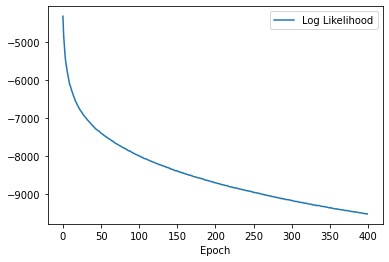

In [14]:
import pandas as pd
ll_df = pd.read_csv('training_logs/dwave_k100_e400_ll.csv', names=['Log Likelihood'], skiprows=1)
ll_df.index.name = 'Epoch'
ll_df.plot()

## 3 Calculating mean of each spins

Text(0.5, 0, 'Spin mean')

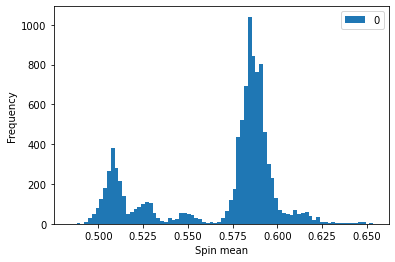

In [20]:
import pandas as pd
samples_numpy = samples.cpu().numpy()
average = samples_numpy.mean(axis=1)
df = pd.DataFrame(average)
ax = df.plot.hist(bins=80)
ax.set_xlabel('Spin mean')

## 4 Calculate correlation between each pairs specified

In [50]:
correlated_df = pd.read_csv('correlated_features.csv', index_col=0)
correlated_df
samples_df = pd.DataFrame(samples_numpy)
# samples_df[correlated_df['left'][0]]


correlations = pd.DataFrame(columns=['correlation'])
for i in correlated_df.index:
    correlations.loc[i] = samples_df[correlated_df['left'][i]].corr(samples_df[correlated_df['right'][i]])


correlations

        


,correlation
0,-0.626150
1,-0.744683
2,0.865052
3,-0.790401
4,-0.631158
...,...
5969,-0.904896
5970,0.692717
5971,-0.931708
5972,0.443240


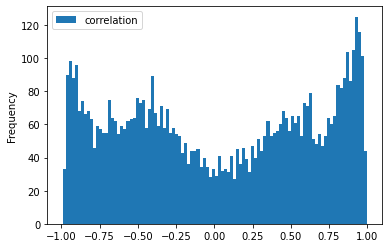

In [52]:
correlations.plot.hist(bins=100)
correlations.to_csv('correlations.csv')